# Concrete Crack Detector

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-19.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Leverage pre-trained models to build image classifiers to detect concrete with and without cracks.

Pre-trained models such as [VGG-16](https://arxiv.org/abs/1409.1556), [Inception](http://arxiv.org/abs/1512.00567), and [ResNet](https://arxiv.org/abs/1512.03385) can be utilized for image classification. These models are trained on large datasets like [ImageNet](https://www.image-net.org/), which contain over a million images and can classify images into 1000 object categories. By leveraging these pre-trained models, we can fine-tune them for specific tasks with smaller datasets, improving accuracy and reducing the need for extensive training data.

## Import libraries

In [1]:
import os
import tensorflow as tf
from keras import utils, applications, Input, layers, Model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-03-07 02:42:29.359798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741336949.372462  462140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741336949.376536  462140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 02:42:29.389194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
%%bash

wget -nc --progress=bar:force:noscroll https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/concrete_data_week3.zip -P /tmp
unzip -qn /tmp/concrete_data_week3.zip -d /tmp

File '/tmp/concrete_data_week3.zip' already there; not retrieving.



## Load the dataset

In [3]:
image_size = (64, 64) # Reduce image size to speed up training and reduce memory consumption
batch_size = 100

ds_train = utils.image_dataset_from_directory(directory='/tmp/concrete_data_week3/train',
                                              image_size=image_size,
                                              batch_size=batch_size)

ds_validation, ds_test = utils.image_dataset_from_directory(directory='/tmp/concrete_data_week3/valid',
                                                            image_size=image_size,
                                                            batch_size=batch_size,
                                                            seed=0,
                                                            subset="both",
                                                            validation_split=0.5)

classes = ds_train.class_names

Found 10001 files belonging to 2 classes.


I0000 00:00:1741336952.146354  462140 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1758 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 5001 files belonging to 2 classes.
Using 2501 files for training.
Using 2500 files for validation.


## Visualize the dataset

The `negative` class represents the concrete images with no cracks and the `positive` class represents the concrete images with cracks.

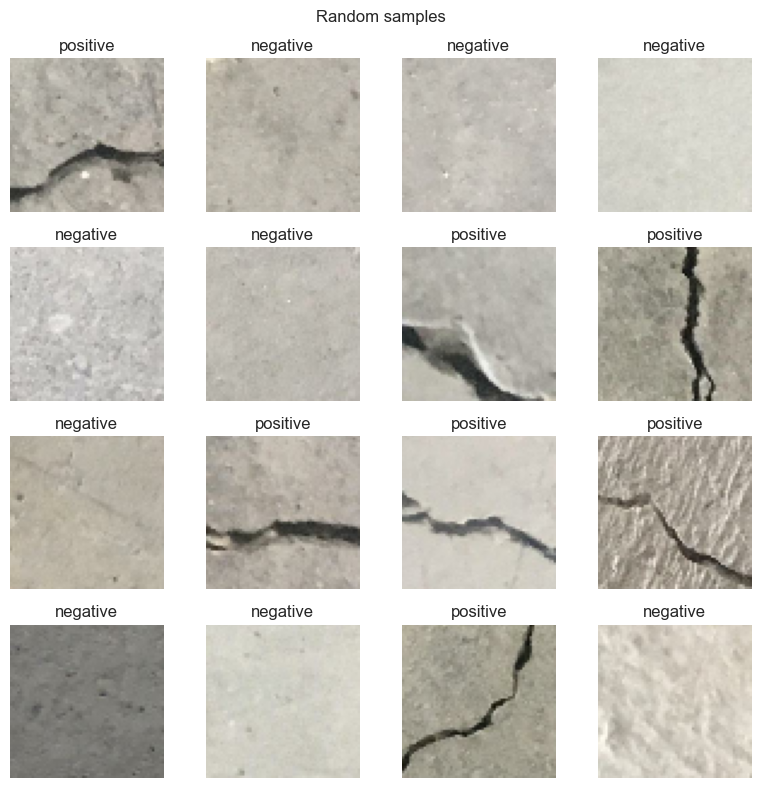

In [4]:
images, labels = next(iter(ds_train))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i] / 255)
    ax.set_title(classes[labels[i].numpy()])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualize the class distribution

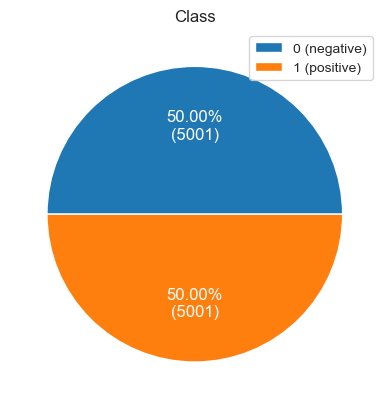

In [5]:
_, _, negative_files = next(os.walk("/tmp/concrete_data_week3/train/negative"))
_, _, positive_files = next(os.walk("/tmp/concrete_data_week3/train/positive"))
sizes = [len(negative_files), len(positive_files)]

fig, ax = plt.subplots()
ax.pie(sizes, textprops={'color': "w", 'fontsize': '12'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(["0 (negative)", "1 (positive)"])
ax.set_title("Class")
plt.show()

## Build an image classifier using the ResNet50 architecture as a base

In [6]:
input_shape = (64, 64, 3)
ResNet50 = applications.ResNet50(include_top=False, input_shape=input_shape, pooling="avg")
ResNet50.trainable = False

inputs = Input(shape=input_shape)
x = applications.resnet.preprocess_input(inputs) # Preprocess our images the same way the images used to train ResNet50 model were processed
x = ResNet50(x, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_resnet = Model(inputs, outputs)
model_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64)    │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 64, 64, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ resnet50[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Compile and train the model

In [7]:
model_resnet.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])

epochs = 5
history_resnet = model_resnet.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/5


I0000 00:00:1741336960.082890  462220 service.cc:148] XLA service 0x7f6cb8001e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741336960.082915  462220 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-07 02:42:40.218994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741336961.058020  462220 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-07 02:42:41.463080: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[100,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,64,16,16]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_c

  3/101 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - binary_accuracy: 0.7694 - loss: 0.5314 

I0000 00:00:1741336963.422988  462220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/101 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.9420 - loss: 0.1842

2025-03-07 02:42:48.362201: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,16,16]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-07 02:42:48.493109: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,8,8]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFo

101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - binary_accuracy: 0.9430 - loss: 0.1814 - val_binary_accuracy: 0.9940 - val_loss: 0.0308
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - binary_accuracy: 0.9962 - loss: 0.0193 - val_binary_accuracy: 0.9964 - val_loss: 0.0203
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - binary_accuracy: 0.9979 - loss: 0.0115 - val_binary_accuracy: 0.9968 - val_loss: 0.0164
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - binary_accuracy: 0.9985 - loss: 0.0084 - val_binary_accuracy: 0.9968 - val_loss: 0.0143
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - binary_accuracy: 0.9987 - loss: 0.0066 - val_binary_accuracy: 0.9968 - val_loss: 0.0131


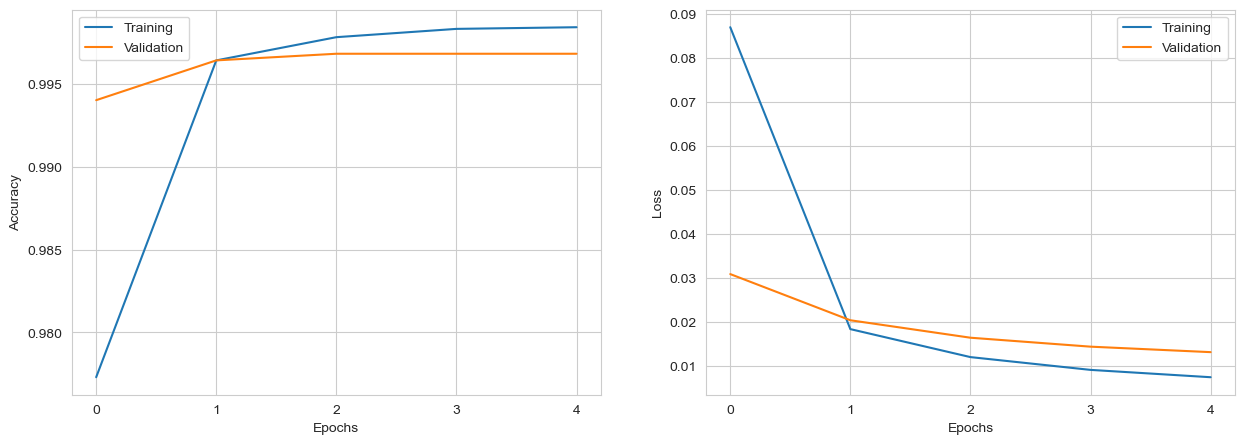

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_resnet.history['binary_accuracy'])
ax1.plot(history_resnet.history['val_binary_accuracy'])
ax1.set_xticks(range(epochs))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_resnet.history['loss'])
ax2.plot(history_resnet.history['val_loss'])
ax2.set_xticks(range(epochs))
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

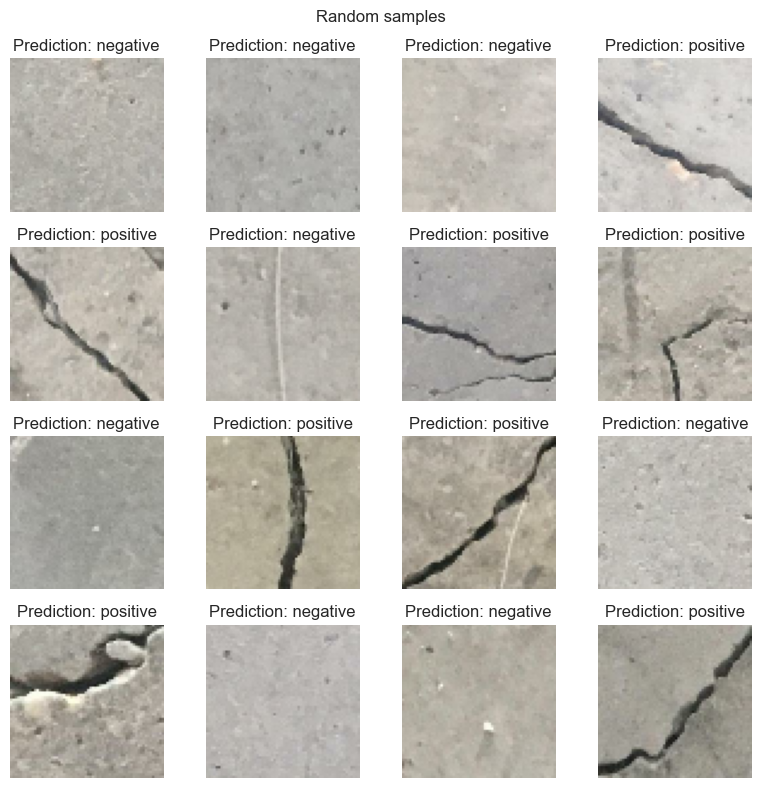

In [9]:
images, labels = next(iter(ds_test))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for i, ax in enumerate(axs.flatten()):
    prediction_proba = model_resnet.predict(tf.expand_dims(images[i], axis=0), verbose=0)
    ax.imshow(images[i] / 255)
    ax.set_title("Prediction: " + classes[int(prediction_proba.squeeze().round())])
    ax.axis("off")

plt.tight_layout()
plt.show()

2025-03-07 02:43:19.602946: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0     0.9960    0.9984    0.9972      1249
           1     0.9984    0.9960    0.9972      1251

    accuracy                         0.9972      2500
   macro avg     0.9972    0.9972    0.9972      2500
weighted avg     0.9972    0.9972    0.9972      2500



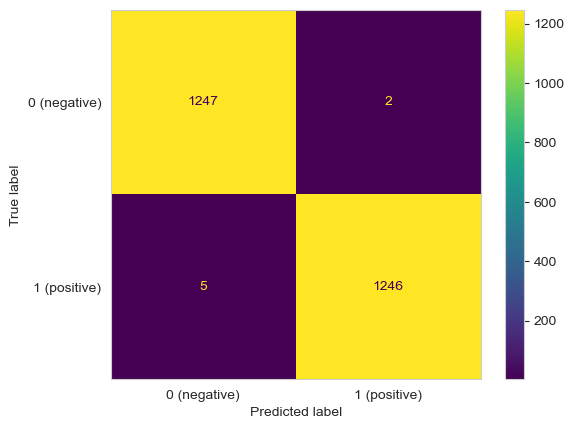

In [10]:
_, y_test = zip(*ds_test.unbatch())
y_test = [y.numpy() for y in y_test]

prediction_proba = model_resnet.predict(ds_test, verbose=0)
y_pred = prediction_proba.squeeze().round()

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (negative)", "1 (positive)"])
plt.grid(False)
plt.show()

## Build an image classifier using the VGG16 architecture as a base

In [11]:
input_shape = (64, 64, 3)
VGG16 = applications.VGG16(include_top=False, input_shape=input_shape, pooling="avg")
VGG16.trainable = False

inputs = Input(shape=input_shape)
x = applications.vgg16.preprocess_input(inputs) # Preprocess our images the same way the images used to train VGG16 model were processed
x = VGG16(x, training=False)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_vgg = Model(inputs, outputs)
model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64, 3) │          0 │ stack_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ vgg16[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile and train the model

In [12]:
model_vgg.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])

epochs = 5
history_vgg = model_vgg.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/5


2025-03-07 02:43:24.550424: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[100,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,3,64,64]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-07 02:43:24.739802: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[100,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - binary_accuracy: 0.8105 - loss: 0.5264

2025-03-07 02:43:38.527962: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-07 02:43:38.609825: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,32]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivation

101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - binary_accuracy: 0.8126 - loss: 0.5205 - val_binary_accuracy: 0.9816 - val_loss: 0.0648
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - binary_accuracy: 0.9894 - loss: 0.0417 - val_binary_accuracy: 0.9900 - val_loss: 0.0392
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - binary_accuracy: 0.9927 - loss: 0.0254 - val_binary_accuracy: 0.9940 - val_loss: 0.0290
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - binary_accuracy: 0.9952 - loss: 0.0176 - val_binary_accuracy: 0.9940 - val_loss: 0.0238
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - binary_accuracy: 0.9963 - loss: 0.0136 - val_binary_accuracy: 0.9956 - val_loss: 0.0203


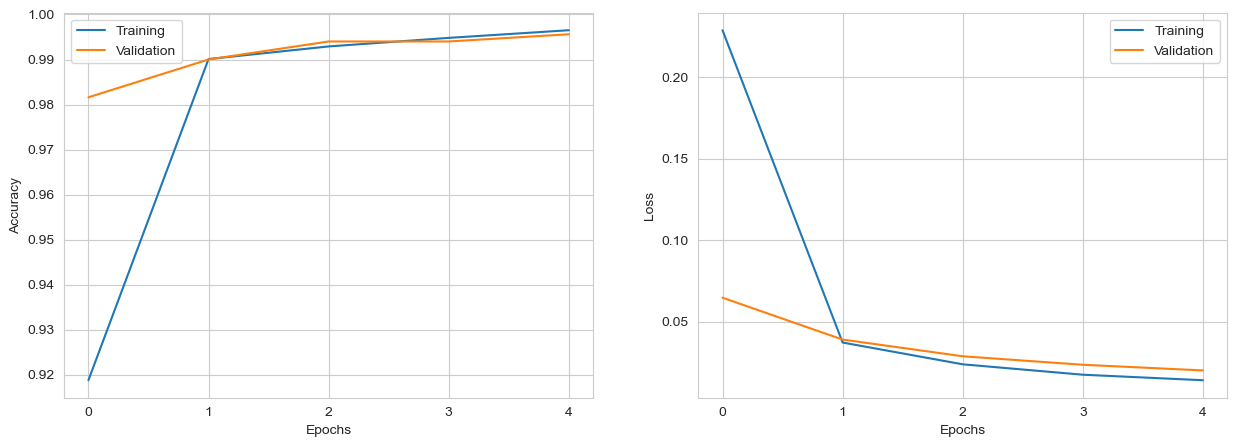

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_vgg.history['binary_accuracy'])
ax1.plot(history_vgg.history['val_binary_accuracy'])
ax1.set_xticks(range(epochs))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history_vgg.history['loss'])
ax2.plot(history_vgg.history['val_loss'])
ax2.set_xticks(range(epochs))
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

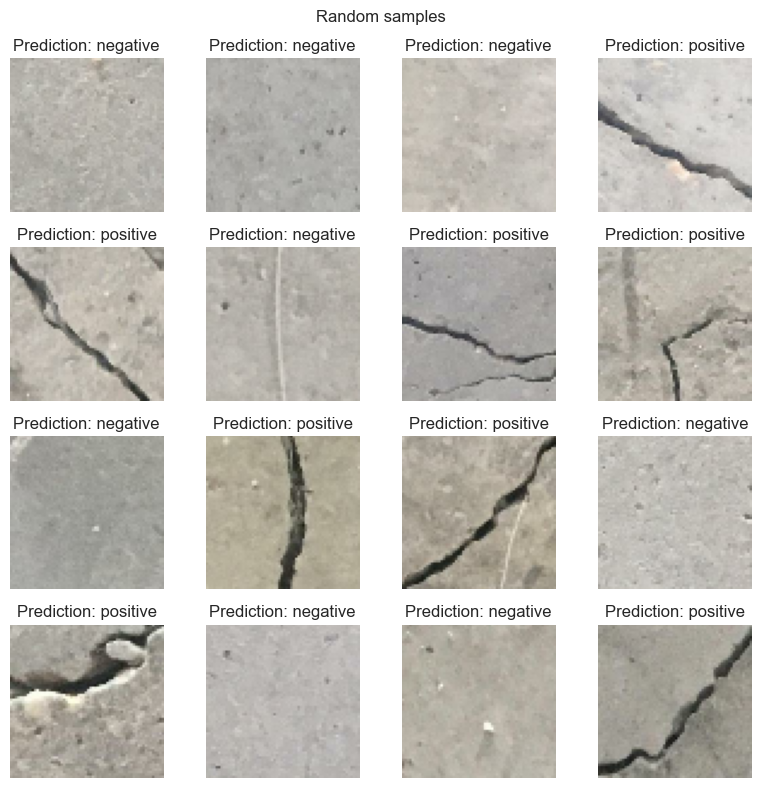

In [14]:
images, labels = next(iter(ds_test))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for i, ax in enumerate(axs.flatten()):
    prediction_proba = model_vgg.predict(tf.expand_dims(images[i], axis=0), verbose=0)
    ax.imshow(images[i] / 255)
    ax.set_title("Prediction: " + classes[int(prediction_proba.squeeze().round())])
    ax.axis("off")

plt.tight_layout()
plt.show()

2025-03-07 02:44:31.798964: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0     0.9984    0.9944    0.9964      1249
           1     0.9944    0.9984    0.9964      1251

    accuracy                         0.9964      2500
   macro avg     0.9964    0.9964    0.9964      2500
weighted avg     0.9964    0.9964    0.9964      2500



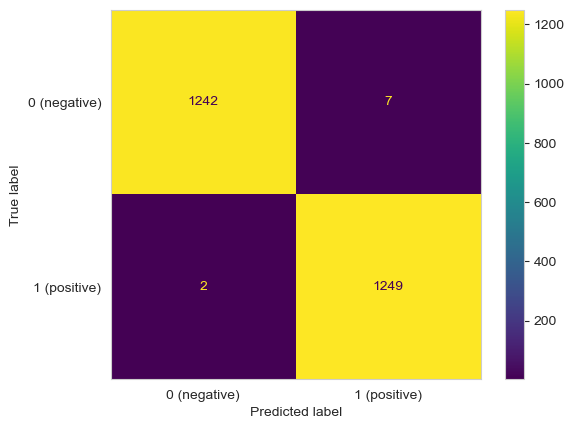

In [15]:
_, y_test = zip(*ds_test.unbatch())
y_test = [y.numpy() for y in y_test]

prediction_proba = model_vgg.predict(ds_test, verbose=0)
y_pred = prediction_proba.squeeze().round()

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (negative)", "1 (positive)"])
plt.grid(False)
plt.show()